In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.utils import class_weight
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.models import load_model
import joblib
import py_vollib.black_scholes.implied_volatility
import multiprocessing
from multiprocessing import Pool
import os
import py_vollib.black_scholes.implied_volatility as vb
%matplotlib inline

Using TensorFlow backend.
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tenso

In [2]:
# Set all file paths

## ---->>> File paths for datasets

nfty = '/home/sharan/Desktop/Option Pricing Work/Work/nifty_2015_2018_feature_set_COV_new_FINAL.csv'
# b_nfty = '/home/sharan/Desktop/Option Pricing Work/Work/BANKNIFTY_feature_setFinal_0.02_Cov.csv'

nfty_ecdf = '/home/sharan/Desktop/Option Pricing Work/Work/nifty_2015_2018_feature_set_ecdf_new_FINAL.csv'
# b_nfty_ecdf = '/home/sharan/Desktop/Option Pricing Work/Work/BANKNIFTY_feature_set_FINAL_ecdf.csv'




## ---->>> File paths for saving models and pickle bits
save_model = '/home/sharan/Desktop/Option Pricing Work/Work/'
save_pickle = '/home/sharan/Desktop/Option Pricing Work/Work/NewTTM/'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 2                       #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage','strike','spot','opPrice']
    
#     b_feats = pd.read_csv(b_nfty_ecdf)
    
else:
    feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
#     b_feats = pd.read_csv(b_nfty)
    
    if (approach == 2):
        dropNames= ['date', 'percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp','avg_atmError']
        
    else:
#         feats=feats[feats['change_oi']!=-5000]
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        

###################

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']

X = X.drop(dropNames, axis = 1)    
    


# b_X = b_feats.iloc[:,:-1]
# b_Y = b_feats.loc[:,'Target']
# b_X = b_X.drop(dropNames, axis = 1)    




Approach var set to :: 2


In [4]:
X.columns

Index(['close_mean', 'close_sd', 'open_mean', 'open_sd', 'high_mean',
       'high_sd', 'low_mean', 'low_sd', 'close_lr_open_lr_cov',
       'close_lr_high_lr_cov', 'close_lr_low_lr_cov', 'open_lr_high_lr_cov',
       'open_lr_low_lr_cov', 'high_lr_low_lr_cov', 'ttm', 'atmError',
       'yield03'],
      dtype='object')

In [5]:
# Start the scaling process

featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)


In [6]:
# # Save the scalar file

joblib.dump(scaler, save_pickle+'DL_SCALER_NIFTY_0.02_Expt'+str(approach)+'.model')
print("Scaler saved to path ::", save_pickle+'DL_SCALER_NIFTY_0.02_Expt'+str(approach)+'.model' )

Scaler saved to path :: /home/sharan/Desktop/Option Pricing Work/Work/NewTTM/DL_SCALER_NIFTY_0.02_Expt2.model


In [7]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
print(class_weights)

[0.35568421 0.4152381  0.47341506 0.49782689 0.53003922 0.54390342
 0.59280702 0.59673289 0.66745679 0.64515513 0.71893617 0.79976331
 0.76795455 0.83950311 0.88339869 0.86089172 0.9723741  0.91324324
 0.98656934 1.05182879 1.14542373 0.96542857 1.08128    1.17530435
 1.32509804 1.24571429 1.15521368 1.22872727 1.48527473 1.33821782
 1.36525253 1.3516     1.57162791 1.6895     1.51865169 1.63830303
 1.41528796 1.48527473 1.63830303 1.86427586 1.89034965 1.91716312
 1.89034965 1.97313869 2.67643564 3.03730337 3.51064935 4.15876923
 4.74245614 1.55356322]


In [8]:
onehot = OneHotEncoder(sparse=False)
Y = Y.values
Y = Y.reshape(len(Y), 1)
Y = onehot.fit_transform(Y)
joblib.dump(onehot, save_pickle+'DL_ONEHOT_NIFTY_0.02_Expt'+str(approach)+'.model')

['/home/sharan/Desktop/Option Pricing Work/Work/NewTTM/DL_ONEHOT_NIFTY_0.02_Expt2.model']

In [9]:
# Split the train and test sets without random optimizations


a = len(feats)
split_val = round(a*0.8)

# Removing the Random splits

X_train = X.iloc[0:split_val, :]
X_test = X.iloc[split_val:, :]
Y_train = Y[:split_val]
Y_test = Y[split_val:]
print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)




X & Y_Dim of Train is (10813, 17) (10813, 50)
X & Y_Dim of Test is (2703, 17) (2703, 50)


In [10]:
# opt=optimizers.Adam(lr=0.00012);
opt=optimizers.Adam(lr=0.0005);
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu',input_dim=X_train.shape[1]))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(units=128, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=64, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=50, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],)
history=model.fit(X_train, Y_train,
  batch_size=32,
  epochs=50,
  verbose=1,
#   class_weight=class_weights,
  validation_data=(X_test, Y_test),
  shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3250      
Total params: 13,810
Trainable params: 13,810
Non-trainable params: 0
_________________________________________________________________
Train on 10813 samples, validate on 2703 samples
Epoch 1/50
10813/10813 [==============================] - 1s 127us/step - loss: 3.5445 - acc: 0.0618 - val_loss: 3.3851 - val_acc: 0.0844
Epoch 2/50
10813/10813 [==============================] - 1s 72us/step - loss: 2.8593 - acc: 0.1297 - val_loss: 2.9292 - val_acc: 0.1384
Epoch 3/50
10813/10813 [==============================] - 1s 68us/step - loss:

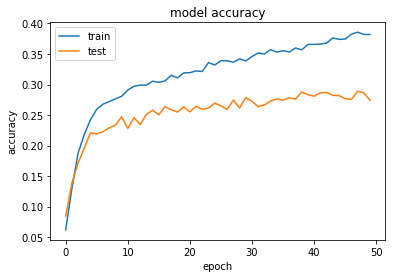

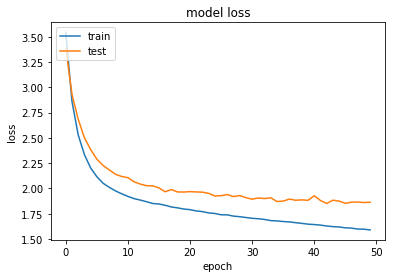

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Saving the model
joblib.dump(model, save_model+'DL_NIFTY_0.02_Expt'+str(approach)+'.model')
print("Model saved to path ::", save_model+'DL_NIFTY_0.02_Expt'+str(approach)+'.model' )

Model saved to path :: /home/sharan/Desktop/Option Pricing Work/Work/DL_NIFTY_0.02_Expt2.model


In [13]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1]*100)

Y_pred=model.predict(X_test)
Y_pred=np.argmax(Y_pred,axis=1)

Test accuracy: 27.41398446336306


In [14]:
OGY_test=onehot.inverse_transform(Y_test)
# OGY_test=sum(OGY_test, [])
OGY_test=OGY_test.ravel()
# print(OGY_test)

# # Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)

# Normalized Error Metric (NEM)

dist_sum = 0
for i in range(len(Y_pred)):
    dist = abs(Y_pred[i] - OGY_test[i])
    dist_sum = dist_sum + dist
    
print((dist_sum*bin_width)/len(Y_test)*100)

13.155752867184612


In [15]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(OGY_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       153
           1       0.62      0.59      0.60        88
           2       0.57      0.54      0.55        63
           3       0.50      0.46      0.48        50
           4       0.34      0.51      0.41        49
           5       0.17      0.19      0.18        36
           6       0.34      0.22      0.27        50
           7       0.38      0.21      0.27        53
           8       0.26      0.26      0.26        42
           9       0.38      0.27      0.32        62
          10       0.40      0.38      0.39        55
          11       0.21      0.33      0.25        45
          12       0.30      0.12      0.17        57
          13       0.21      0.29      0.24        55
          14       0.04      0.03      0.04        64
          15       0.21      0.35      0.26        57
          16       0.00      0.00      0.00        60
          17       0.17    

/home/sharan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DL_NEM = []
DL_D_NEM = []

path="/home/sharan/Desktop/Option Pricing Work/Work/Serial GBM Runs/"

sigma = np.linspace(0.01, 0.2, 20)

for si in sigma:
    si=round(si,2)
    feats = pd.read_csv(path+"GBM_feature_set_final_ecdf_"+str(si)+".csv")
    X=feats.iloc[:,:-1]
    X['atmError']=X['atmError']*100
    Y=feats.loc[:,'Target']
    dr = ['percentage']
    X = X.drop(dr, axis = 1)
    featNames=list(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=featNames)
    
    Y = Y.values
    
    Y_pred = model.predict(X)
    Y_pred = np.argmax(Y_pred,axis=1)
    
    dist_sum = 0
    d_dist_sum = 0
    for i in range(len(Y_pred)):
        dist = abs(Y_pred[i] - Y[i]) # NEM
        d_dist = (Y_pred[i] - Y[i]) # Directional NEM (NEM without the mod)
        
        dist_sum = dist_sum + dist # NEM
        d_dist_sum = d_dist_sum + d_dist
    
    nem = (dist_sum*bin_width)/len(Y)*100
    d_nem = (d_dist_sum*bin_width)/len(Y)*100
    
    DL_NEM.append(nem)
    DL_D_NEM.append(d_nem)
    
dresults=pd.DataFrame({'sigma' : sigma, 
              'nem': DL_NEM, 
              'd_nem' : DL_D_NEM})
dresults.to_csv(path+"DresultsGBM.csv" ,index=False)    

DL_NEM = []
DL_D_NEM = []
path="/home/sharan/Desktop/Option Pricing Work/Work/Binomial/"

U=[]
D=[]
for i in range(1,10):
    u=1+(i*pow(10,-3))
    d=1/u
    U.append(u)
    D.append(d)

for u in U:
    u=round(u,5)
    feats = pd.read_csv(path+"BM_feature_set_final_ecdf_"+str(u)+".csv")
    X=feats.iloc[:,:-1]
    X['atmError']=X['atmError']*100
    Y=feats.loc[:,'Target']
    dr = ['percentage']
    X = X.drop(dr, axis = 1)
    featNames=list(X)    
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=featNames)
    
    Y = Y.values
    
    Y_pred = model.predict(X)
    Y_pred = np.argmax(Y_pred,axis=1)
    
    dist_sum = 0
    d_dist_sum = 0
    for i in range(len(Y_pred)):
        dist = abs(Y_pred[i] - Y[i]) # NEM
        d_dist = (Y_pred[i] - Y[i]) # Directional NEM (NEM without the mod)
        
        dist_sum = dist_sum + dist # NEM
        d_dist_sum = d_dist_sum + d_dist
    
    nem = (dist_sum*bin_width)/len(Y)*100
    d_nem = (d_dist_sum*bin_width)/len(Y)*100
    
    DL_NEM.append(nem)
    DL_D_NEM.append(d_nem)
    
dresults=pd.DataFrame({'U' : U, 
              'nem': DL_NEM, 
              'd_nem' : DL_D_NEM})
dresults.to_csv(path+"DresultsBM.csv" ,index=False)    

def worker(date,UnderlyingPrice, StrikePrice, InterestRate, Daystoexpiration,l_callPrice,h_callPrice,a_callPrice):
#     implied_volatility(price, S, K, t, r, flag)
#     l_iv=vb.implied_volatility(l_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
#     h_iv=vb.implied_volatility(h_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
    a_iv=vb.implied_volatility(a_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
    return [date,a_iv]

test_latest_ecdf="/home/sharan/Desktop/Option Pricing Work/Work/nifty_19-20_feature_set_ecdf_new_FINAL.csv"
latest_ecdf_feats = pd.read_csv(test_latest_ecdf)

dropNames = ['date', 'percentage','strike','spot','opPrice']

X_latest=latest_ecdf_feats.iloc[:,:-1]
Y_latest=latest_ecdf_feats.loc[:,'Target']
X_latest = X_latest.drop(dropNames, axis = 1)

featNames = list(X_latest)  
X_latest = scaler.transform(X_latest)
X_latest = pd.DataFrame(X_latest, columns = featNames)
Y_latest = Y_latest.values
Y_latest = Y_latest.reshape(len(Y_latest), 1)
Y_latest = onehot.transform(Y_latest)
score = model.evaluate(X_latest, Y_latest, verbose=0)

Y_latest_pred=model.predict(X_latest)
Y_latest_pred=np.argmax(Y_latest_pred,axis=1)

OGY_latest=onehot.inverse_transform(Y_latest)

OGY_latest=OGY_latest.ravel()
# print(OGY_latest_test)

# # Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)


dist_sum = 0
step = 0.1

date=[]
lower_iv=[]
higher_iv=[]
actual_iv=[]

params=[]

total_res=[]

for i in range(len(Y_latest_pred)):    
    
    lower_bound_opPrice = ((Y_latest_pred[i]*step) * latest_ecdf_feats.loc[i,'strike'])/100
    
    higher_bound_opPrice = (( (Y_latest_pred[i]+1) * step) * latest_ecdf_feats.loc[i,'strike'])/100
    
    actual_opPrice = latest_ecdf_feats.loc[i,'opPrice']
    
    print("\nDate={}".format(latest_ecdf_feats.loc[i,'date']))
    print("Lower={}".format(lower_bound_opPrice))
    print("Higher={}".format(higher_bound_opPrice))
    print("Actual={}".format(actual_opPrice))    
    print("S={}".format(latest_ecdf_feats.loc[i,'spot']))
    print("K={}".format(latest_ecdf_feats.loc[i,'strike']))
    print("TTM={}".format(latest_ecdf_feats.loc[i,'ttm']))
    print("R={}".format(latest_ecdf_feats.loc[i,'yield03']))    
    
#     params.append((latest_ecdf_feats.loc[i,'date'],latest_ecdf_feats.loc[i,'spot'], 
#                    latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm'],
#                   lower_bound_opPrice,higher_bound_opPrice,actual_opPrice))

    res_list=worker(latest_ecdf_feats.loc[i,'date'],latest_ecdf_feats.loc[i,'spot'], 
                   latest_ecdf_feats.loc[i,'strike'],
                   latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm'],
                  lower_bound_opPrice,higher_bound_opPrice,actual_opPrice)
    
    total_res.append(res_list)
#     break

# IV=[]
# pool = Pool()
# for res in pool.starmap(worker,params):    
#     IV.append(res)
    
# pool.close()


    
#     date.append(latest_ecdf_feats.loc[i,'date'])
    
#     lower_bound_opPrice = ((Y_latest_pred[i]*step) * latest_ecdf_feats.loc[i,'strike'])/100
#     print("\nLower={}".format(lower_bound_opPrice))
# #     print("OpPrice={}".format(lower_bound_opPrice))
# #     print("S={}".format(latest_ecdf_feats.loc[i,'spot']))
# #     print("K={}".format(latest_ecdf_feats.loc[i,'strike']))
# #     print("TTM={}".format(latest_ecdf_feats.loc[i,'ttm']/365))
# #     print("R={}".format(latest_ecdf_feats.loc[i,'yield03']))
#     #BS([UnderlyingPrice, StrikePrice, InterestRate, Daystoexpiration],callPrice=x)
#     l_iv = mibian.BS([latest_ecdf_feats.loc[i,'spot'], latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm']],
#                                callPrice=lower_bound_opPrice)

#     lower_iv.append(l_iv.impliedVolatility)
#     print(lower_iv)
    
#     higher_bound_opPrice = (( (Y_latest_pred[i]+1) * step) * latest_ecdf_feats.loc[i,'strike'])/100
#     print("Higher={}".format(higher_bound_opPrice))
    
#     h_iv = mibian.BS([latest_ecdf_feats.loc[i,'spot'], latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm']],
#                                callPrice=higher_bound_opPrice)
    
#     higher_iv.append(h_iv.impliedVolatility)
#     print(higher_iv)

#     actual_opPrice = latest_ecdf_feats.loc[i,'opPrice']
#     print("Actual={}".format(actual_opPrice))
    
#     a_iv = mibian.BS([latest_ecdf_feats.loc[i,'spot'], latest_ecdf_feats.loc[i,'strike'],
#                    latest_ecdf_feats.loc[i,'yield03'], latest_ecdf_feats.loc[i,'ttm']],
#                                callPrice=actual_opPrice)
    
#     actual_iv.append(a_iv.impliedVolatility)    
#     print(actual_iv)
#     break

vola_names=['Date','LowerBoundIV','HigherBoundIV','ActualIV']
vola_dataSet=pd.DataFrame.from_records(IV, columns=vola_names)
vola_dataSet

Lower=317.8
Higher=329.1500000000001
Actual=324.8
S=11713.2
K=11350.0
TTM=2.0
R=6.18